In [3]:
!nvidia-smi

Sun Nov 13 09:29:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [6]:
BATCH_SIZE = 32
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)

In [7]:
# Loading the data from disk
dataset_path = '/content/drive/MyDrive/Research-Work/Datasets/Bangladeshi_Paddy_Diseases'
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    shuffle = True,
    seed = 123,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
)

Found 6564 files belonging to 9 classes.


In [8]:
class_names = dataset.class_names
print(class_names)

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'blast', 'brown_spot', 'false_smut', 'normal', 'sheath_blight', 'sheath_rot', 'tungro']


In [9]:
print(len(class_names))

9


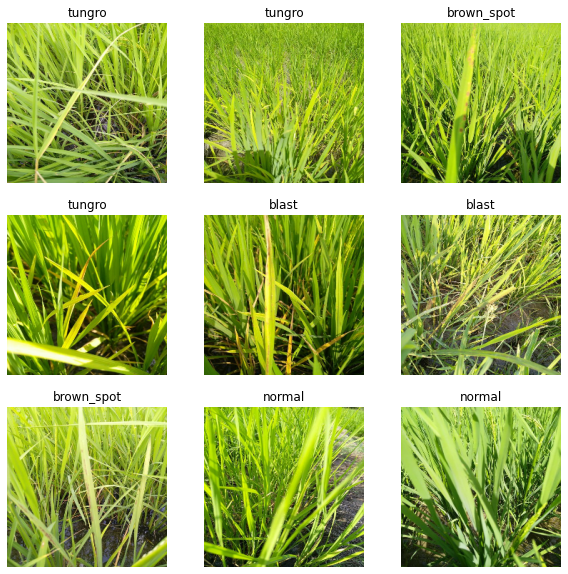

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
# Dataset Spliting Function.
def dataset_partitions(ds, train_split = 0.6, vali_split = 0.2, test_split = 0.1, shuffle = True, shuffle_size=1000):
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 123)
        
    dataset_size = len(ds)
    train_size = int(dataset_size*train_split)
    train_ds = ds.take(train_size)
    val_size = int(dataset_size * vali_split)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [12]:
# Spliting the dataset of 6564 images into 70% train, 20% validation and 10% test dataset
train_ds, val_ds, test_ds = dataset_partitions(dataset)

In [13]:
# # # Resizing the dataset
# train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))
# val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))
# test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y))

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
# test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [15]:

print(len(train_ds))
print(len(val_ds))
print(len(test_ds))
print(train_ds)

123
41
42
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [16]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(height_factor=0.4, width_factor=0.4),
    ],
    name="data_augmentation" )

# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip('horizontal'),
#   tf.keras.layers.RandomRotation(0.2),
# ])

# data_augmentation = keras.Sequential(
#     [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
# )

In [17]:
# preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [18]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model =  tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE,
)

In [19]:
IMG_SHAPE

(224, 224, 3)

In [20]:
base_model.trainable = False

In [21]:
inputs = keras.Input(shape=(img_height, img_height, 3))
x = data_augmentation(inputs) 
x = tf.keras.applications.inception_resnet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(9)(x)
model = keras.Model(inputs, outputs)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      7         
 al)                                                             
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                       

In [22]:
# tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
epochs_1=100
history = model.fit(train_ds,
                    epochs=epochs_1,
                    batch_size = BATCH_SIZE,
                    validation_data=val_ds,
                    verbose=1)


Epoch 1/100
123/123 [==============================] - 97s 455ms/step - loss: 1.6349 - accuracy: 0.3798 - val_loss: 1.2747 - val_accuracy: 0.5274
Epoch 2/100
123/123 [==============================] - 30s 245ms/step - loss: 1.4015 - accuracy: 0.4754 - val_loss: 1.1827 - val_accuracy: 0.5663
Epoch 3/100
123/123 [==============================] - 32s 259ms/step - loss: 1.3179 - accuracy: 0.5079 - val_loss: 1.1253 - val_accuracy: 0.5991
Epoch 4/100
123/123 [==============================] - 32s 260ms/step - loss: 1.2621 - accuracy: 0.5173 - val_loss: 1.1726 - val_accuracy: 0.5686
Epoch 5/100
123/123 [==============================] - 34s 280ms/step - loss: 1.2434 - accuracy: 0.5409 - val_loss: 1.0675 - val_accuracy: 0.6075
Epoch 6/100
123/123 [==============================] - 31s 254ms/step - loss: 1.2170 - accuracy: 0.5511 - val_loss: 1.0266 - val_accuracy: 0.6235
Epoch 7/100
123/123 [==============================] - 32s 261ms/step - loss: 1.1945 - accuracy: 0.5536 - val_loss: 1.0762 -

In [24]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

epochs_2 = 30
history_2 = model.fit(train_ds, epochs=epochs_2, validation_data=val_ds)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      7         
 al)                                                             
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                       

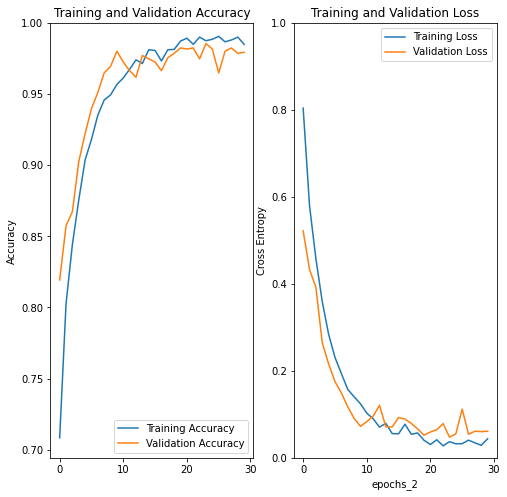

In [25]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epochs_2')
plt.show()

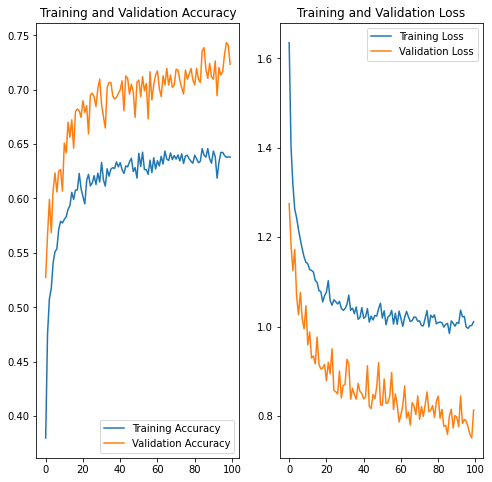

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs_1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

42/42 [==============================] - 31s 179ms/step - loss: 0.0894 - accuracy: 0.9784


In [28]:
print(test_loss)

0.08944517374038696


In [29]:
print(test_acc)

0.9784226417541504


In [30]:
import seaborn as sns

In [31]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [32]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0) 
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [33]:
labels = ['bacterial_leaf_blight', 'bacterial_leaf_streak', 'blast', 'brown_spot', 'false_smut', 'normal', 'sheath_blight', 'sheath_rot', 'tungro']


123/123 [==============================] - 25s 176ms/step


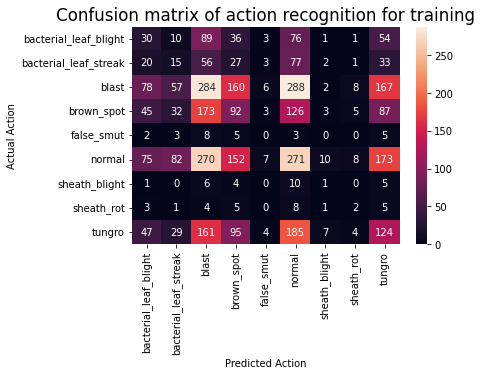

In [34]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

42/42 [==============================] - 29s 175ms/step


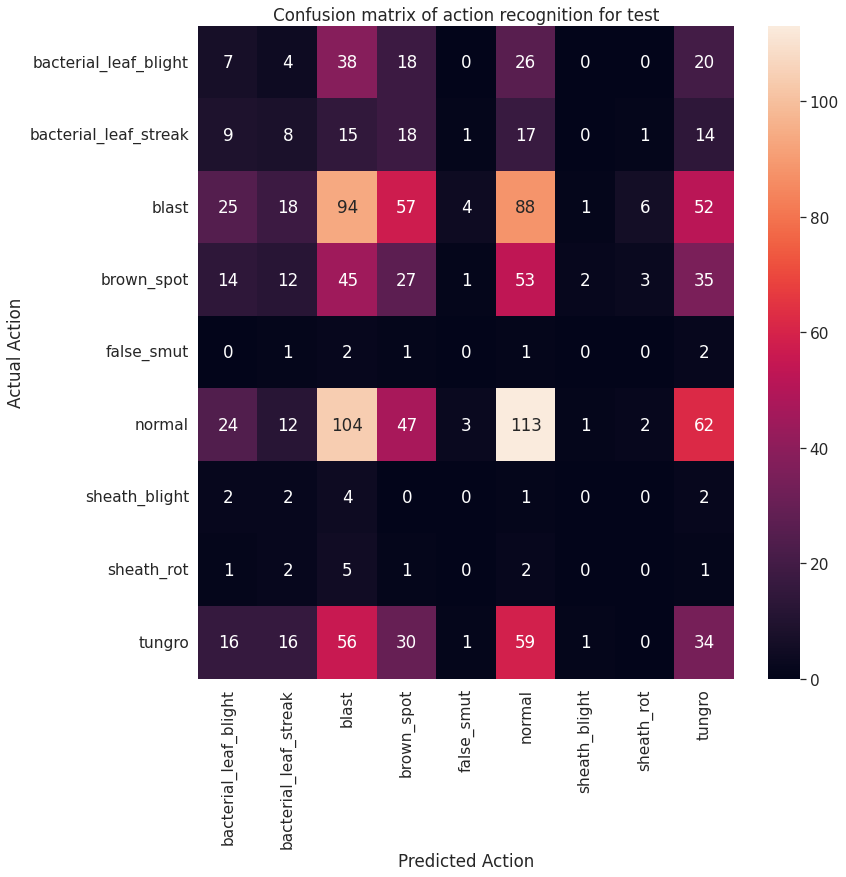

In [35]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')


In [36]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [37]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [38]:
precision

{'bacterial_leaf_blight': 0.07142857142857142,
 'bacterial_leaf_streak': 0.10666666666666667,
 'blast': 0.25895316804407714,
 'brown_spot': 0.135678391959799,
 'false_smut': 0.0,
 'normal': 0.3138888888888889,
 'sheath_blight': 0.0,
 'sheath_rot': 0.0,
 'tungro': 0.15315315315315314}

In [39]:
recall

{'bacterial_leaf_blight': 0.061946902654867256,
 'bacterial_leaf_streak': 0.0963855421686747,
 'blast': 0.27246376811594203,
 'brown_spot': 0.140625,
 'false_smut': 0.0,
 'normal': 0.3070652173913043,
 'sheath_blight': 0.0,
 'sheath_rot': 0.0,
 'tungro': 0.1596244131455399}

In [40]:
# Saving the model
model_version = 'InceptionResNetV2'
model_path = '/content/drive/MyDrive/Research-Work/Datasets/Models'
model.save(f"{model_path}/{model_version}")